# **SENTIMENT ANALYSIS ON PAPER REVIEWS USING MACHINE LEARNING AND DEEP LEARNING MODELS**


**INSTALLING THE REQUIRED LIBRARIES**

In [2]:
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install deep-translator
!pip install nltk
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 80.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.7 MB/s eta 0:00:00


**IMPORTING THE REQUIRED LIBRARIES**

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
import nltk
from deep_translator import GoogleTranslator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from deep_translator import GoogleTranslator


from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import gzip
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping


# **LOADING DATASET AND FLATTENING IT**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Load the JSON file
json_path = "/content/drive/MyDrive/DS_Project/reviews.json"
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Flatten the nested structure into a DataFrame
flattened_reviews = []

for paper in data['paper']:
    paper_id = paper.get('id')
    preliminary_decision = paper.get('preliminary_decision')

    for review in paper['review']:
        flattened_review = {
            'paper_id': paper_id,
            'preliminary_decision': preliminary_decision,
            'review_id': review.get('id'),
            'confidence': review.get('confidence'),
            'evaluation': review.get('evaluation'),
            'orientation': review.get('orientation'),
            'language': review.get('lan'),
            'remarks': review.get('remarks'),
            'text': review.get('text'),
            'timespan': review.get('timespan')
        }
        flattened_reviews.append(flattened_review)

#  Create the DataFrame
df = pd.DataFrame(flattened_reviews)
print("Flattened DataFrame created. Shape:", df.shape)
print(df.head(2))


Mounted at /content/drive
Flattened DataFrame created. Shape: (405, 10)
   paper_id preliminary_decision  review_id confidence evaluation orientation  \
0         1               accept          1          4          1           0   
1         1               accept          2          4          1           1   

  language remarks                                               text  \
0       es          - El artículo aborda un problema contingente y...   
1       es          El artículo presenta recomendaciones prácticas...   

     timespan  
0  2010-07-05  
1  2010-07-05  


**DATASET INFORMATION AND CLASS DISTRIBUTION**

In [7]:
print("Language distribution (UnBalanced Dataset):")
print(df['language'].value_counts())


df.info()

Language distribution (UnBalanced Dataset):
language
es    388
en     17
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   paper_id              405 non-null    int64 
 1   preliminary_decision  405 non-null    object
 2   review_id             405 non-null    int64 
 3   confidence            403 non-null    object
 4   evaluation            405 non-null    object
 5   orientation           405 non-null    object
 6   language              405 non-null    object
 7   remarks               405 non-null    object
 8   text                  405 non-null    object
 9   timespan              405 non-null    object
dtypes: int64(2), object(8)
memory usage: 31.8+ KB


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipython-input-9-308511085.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='language', palette='Set2')


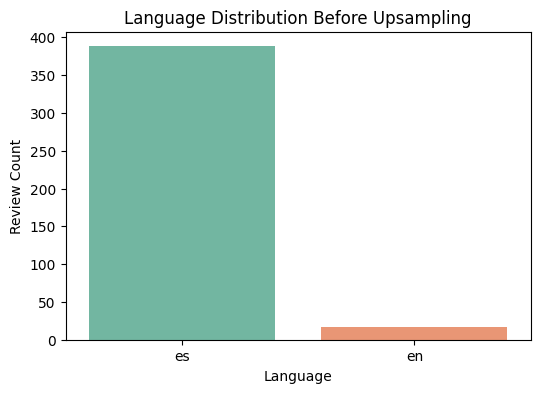

In [9]:

# Downloads for NLTK
nltk.download('punkt')
nltk.download('stopwords')


# Plot bar chart
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='language', palette='Set2')
plt.title('Language Distribution Before Upsampling')
plt.xlabel('Language')
plt.ylabel('Review Count')
plt.show()


If left unbalanced, a model might just predict "es" for everything and still achieve high accuracy.

After balancing, the model gets enough training signals from both classes.

Helps achieve better precision, recall, and fairness in classification

In [14]:
# STEP : Check original language distribution
print("Original language counts:\n", df['language'].value_counts())

# STEP : Upsample English reviews to match Spanish
df_es = df[df['language'] == 'es']
df_en = df[df['language'] == 'en']


# Import resample from sklearn.utils
from sklearn.utils import resample
df_en_upsampled = resample(
    df_en,
    replace=True,
    n_samples=len(df_es),  # match Spanish count
    random_state=42
)

# STEP : Combine and shuffle
df_balanced = pd.concat([df_es, df_en_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# STEP : Confirm new balanced distribution
print("\nBalanced language counts:\n", df_balanced['language'].value_counts())
df_balanced.head()


Original language counts:
 language
es    388
en     17
Name: count, dtype: int64

Balanced language counts:
 language
en    388
es    388
Name: count, dtype: int64


,paper_id,preliminary_decision,review_id,confidence,evaluation,orientation,language,remarks,text,timespan
0,8,accept,2,4,2,1,en,,This manuscript addresses an interesting solut...,2010-07-05
1,69,accept,1,4,0,-1,en,,This is a developed application to support inf...,2013-07-05
2,140,reject,1,4,-2,-2,es,,El artículo realiza una reflexión sobre el est...,2015-07-05
3,19,accept,1,4,2,1,en,,"This paper is very interesting, I like the ide...",2010-07-05
4,159,accept,1,4,0,0,es,"En caso que el trabajo sea aceptado, se recomi...",El artículo presenta una evaluación de técnica...,2015-07-05


### Handling Class Imbalance with Upsampling

In the original dataset, there is a significant class imbalance in the `language` feature:

- Spanish (`es`) reviews: 388  
- English (`en`) reviews: 17  

This imbalance can lead to biased model predictions where the model favors the majority class (`es`) and underperforms on the minority class (`en`). To address this, we apply **upsampling** to the minority class.

**Upsampling** involves randomly replicating examples from the minority class until both classes are equally represented. This ensures that the model receives a balanced number of examples from each class during training.


We have applied upsampling using the `resample()` function from `sklearn.utils`:

/tmp/ipython-input-11-883266213.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_balanced, x='language', palette='Set2')


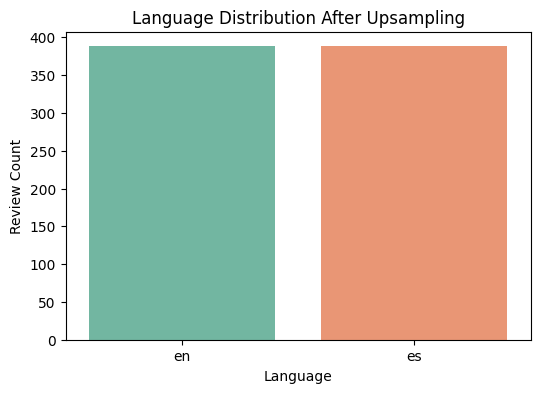

In [11]:
# Plot bar chart
plt.figure(figsize=(6,4))
sns.countplot(data=df_balanced, x='language', palette='Set2')
plt.title('Language Distribution After Upsampling')
plt.xlabel('Language')
plt.ylabel('Review Count')
plt.show()

Original language distribution:
language
es    388
en     17
Name: count, dtype: int64


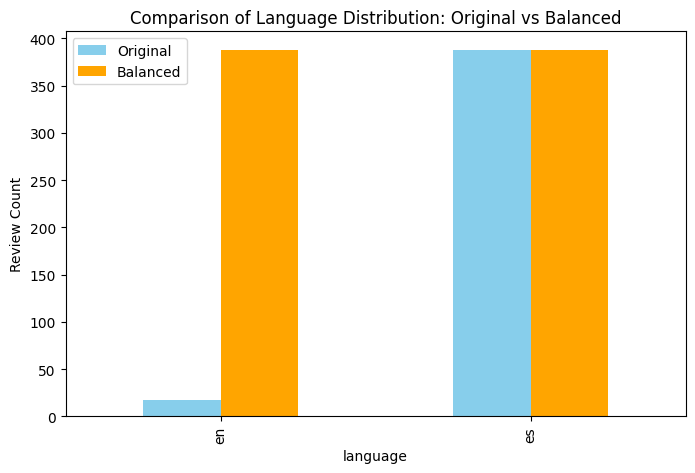

In [15]:
# Original language distribution
print("Original language distribution:")
print(df['language'].value_counts())

# Plot both side by side
lang_counts_original = df['language'].value_counts()
lang_counts_balanced = df_balanced['language'].value_counts()

# Combine into one DataFrame
lang_compare = pd.DataFrame({
    'Original': lang_counts_original,
    'Balanced': lang_counts_balanced
})

lang_compare.plot(kind='bar', figsize=(8,5), color=['skyblue', 'orange'])
plt.title('Comparison of Language Distribution: Original vs Balanced')
plt.ylabel('Review Count')
plt.show()


**DATA PREPROCESSING**

**TRANSLATION + TEXT PREPROCESSING**

Why Translation?

Reviews are in Spanish and English.

Most NLP models (TF-IDF, BERT, etc.) work better on one language.

So we translate Spanish reviews → English for uniform preprocessing and modeling.

What is Text Preprocessing? Essential to clean and prepare raw text:

Lowercasing

Removing punctuation and digits

Tokenization (breaking text into words)

Stopword removal (removing words like “the”, “is”, “an”)

Lemmatization (reducing words to their root: "running" → "run")

This improves performance and reduces noise for all models (Naïve Bayes, Logistic Regression, LSTM, BERT)

In [16]:
# STEP: TRANSLATION + TEXT CLEANING
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load spaCy model
import en_core_web_sm
nlp = en_core_web_sm.load()

# Set up stopwords
stop_words = set(stopwords.words('english'))

# 1. Translate Spanish reviews to English
def translate_text(text, lang):
    if lang == 'es':
        try:
            return GoogleTranslator(source='es', target='en').translate(text)
        except:
            return text  # If fails, return original
    return text

df_balanced['translated_text'] = df_balanced.apply(lambda row: translate_text(row['text'], row['language']), axis=1)

# 2. Clean and preprocess translated text
def preprocess_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation/digits
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words and token.lemma_.isalpha()]
    return " ".join(tokens)

df_balanced['text_clean'] = df_balanced['translated_text'].apply(preprocess_text)

# Check result
df_balanced[['language', 'text', 'translated_text', 'text_clean']].head()



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,language,text,translated_text,text_clean
0,en,This manuscript addresses an interesting solut...,This manuscript addresses an interesting solut...,manuscript address interesting solution base m...
1,en,This is a developed application to support inf...,This is a developed application to support inf...,develop application support information sound ...
2,es,El artículo realiza una reflexión sobre el est...,The article makes a reflection on the current ...,article make reflection current state possible...
3,en,"This paper is very interesting, I like the ide...","This paper is very interesting, I like the ide...",paper interesting I like idea make work publis...
4,es,El artículo presenta una evaluación de técnica...,The article presents an evaluation of genetic ...,article present evaluation genetic algorithm t...


Total reviews after preprocessing: 776
Example cleaned review:
 manuscript address interesting solution base machine learn technique classify spectra legacy datum hubble space telescope order publish result good spectra internet scientific community manuscript wellwritten result robust experiment sound manuscript seem acceptable current form work short interesting infonor jcc community main problem paper difficult compare result classifier utilize confusion matrix parameter classifier could clarify result
text_clean         0
translated_text    0
dtype: int64


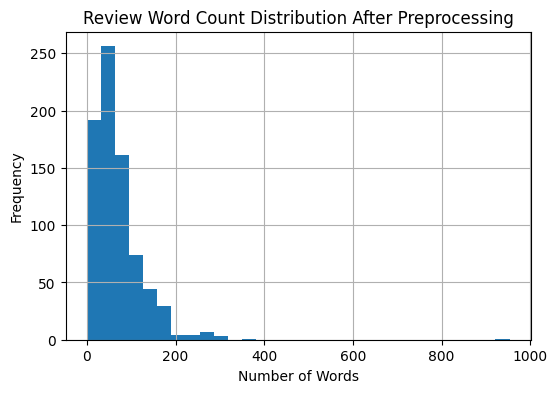

In [17]:

df_balanced[['language', 'text', 'translated_text', 'text_clean']].sample(5, random_state=42)

print(f"Total reviews after preprocessing: {df_balanced.shape[0]}")
print("Example cleaned review:\n", df_balanced['text_clean'].iloc[0])



print(df_balanced[['text_clean', 'translated_text']].isnull().sum())

df_balanced['word_count'] = df_balanced['text_clean'].apply(lambda x: len(x.split()))
df_balanced['word_count'].hist(bins=30, figsize=(6,4))
plt.title("Review Word Count Distribution After Preprocessing")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

The above histogram shows

The distribution is right-skewed, with most reviews being short.

A majority of reviews have 50–100 words.

Few reviews exceed 200 words, forming a long tail.



### **EDA STEP**

In [18]:
# Step 1: Ensure evaluation is numeric
df_balanced['evaluation'] = pd.to_numeric(df_balanced['evaluation'], errors='coerce')
df_balanced = df_balanced.dropna(subset=['evaluation'])
df_balanced['evaluation'] = df_balanced['evaluation'].astype(int)

# Step 2: Map numeric score to sentiment category
def map_sentiment(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

df_balanced['sentiment_label'] = df_balanced['evaluation'].apply(map_sentiment)


In [19]:
# Checking the cleaned data
df_balanced[['evaluation', 'text_clean']].head()

,evaluation,text_clean
0,2,manuscript address interesting solution base m...
1,0,develop application support information sound ...
2,-2,article make reflection current state possible...
3,2,paper interesting I like idea make work publis...
4,0,article present evaluation genetic algorithm t...


/tmp/ipython-input-21-770909190.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_balanced, x='sentiment_label', palette='Set2')


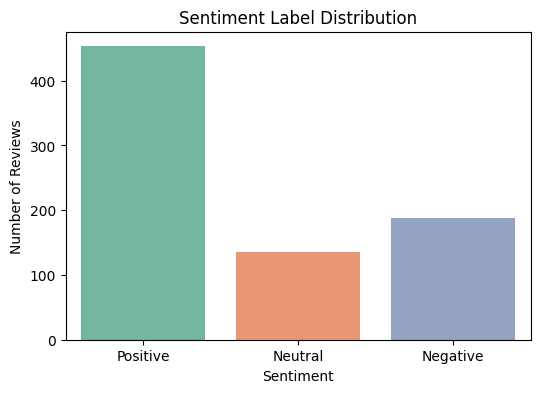

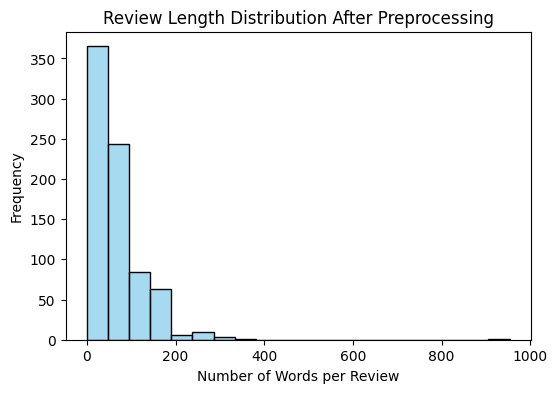

/tmp/ipython-input-21-770909190.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='pastel')


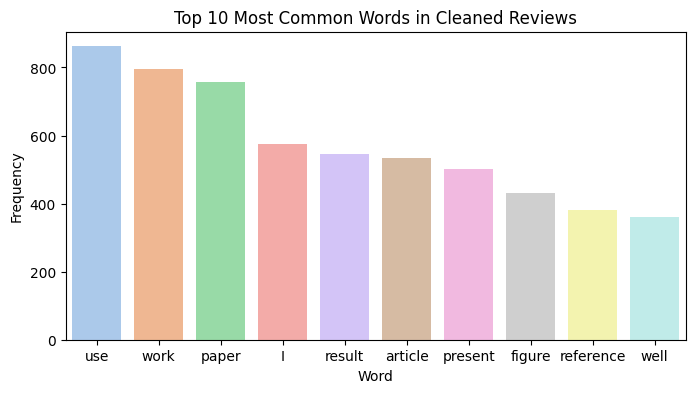

/tmp/ipython-input-21-770909190.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(bigrams), y=list(counts), palette='coolwarm')


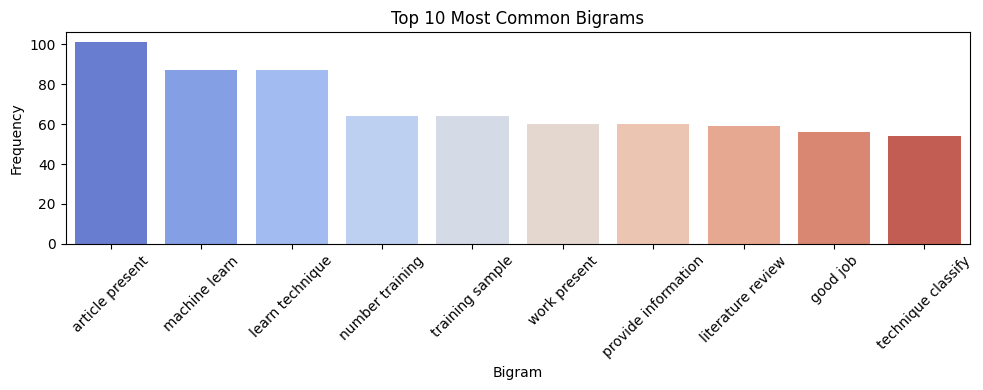

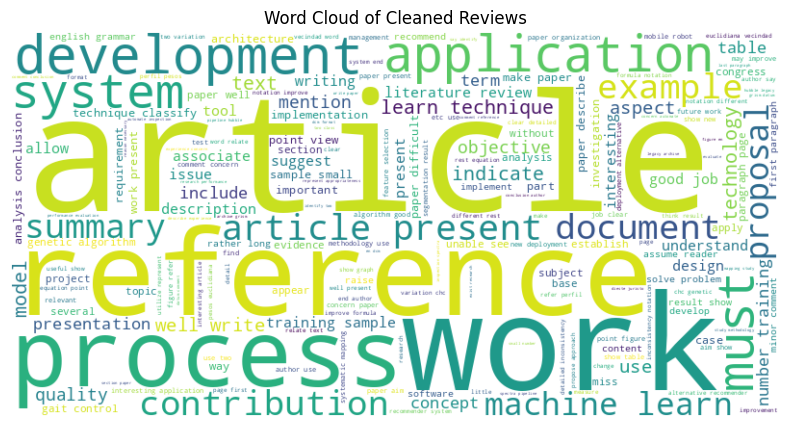

In [21]:
# STEP : EDA FOR SENTIMENT ANALYSIS

# 1️ MAP EVALUATION SCORES TO SENTIMENT LABELS
def map_sentiment(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

df_balanced['sentiment_label'] = df_balanced['evaluation'].apply(map_sentiment)

# 2️ SENTIMENT LABEL DISTRIBUTION
plt.figure(figsize=(6, 4))
sns.countplot(data=df_balanced, x='sentiment_label', palette='Set2')
plt.title("Sentiment Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

# 3️ REVIEW LENGTH DISTRIBUTION
df_balanced['word_count'] = df_balanced['text_clean'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6, 4))
sns.histplot(df_balanced['word_count'], bins=20, kde=False, color='skyblue')
plt.title("Review Length Distribution After Preprocessing")
plt.xlabel("Number of Words per Review")
plt.ylabel("Frequency")
plt.show()

# 4️ WORD FREQUENCY ANALYSIS (TOP UNIGRAMS)
all_words = ' '.join(df_balanced['text_clean']).split()
word_freq = Counter(all_words).most_common(10)
words, counts = zip(*word_freq)
plt.figure(figsize=(8, 4))
sns.barplot(x=list(words), y=list(counts), palette='pastel')
plt.title("Top 10 Most Common Words in Cleaned Reviews")
plt.ylabel("Frequency")
plt.xlabel("Word")
plt.show()

# 5️ N-GRAM ANALYSIS (BIGRAMS)
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X_counts = vectorizer.fit_transform(df_balanced['text_clean'])
sum_words = X_counts.sum(axis=0)

# Extract bigrams and their counts
bigram_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)[:10]
bigrams, counts = zip(*bigram_freq)

# Plot
plt.figure(figsize=(10, 4))
sns.barplot(x=list(bigrams), y=list(counts), palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Top 10 Most Common Bigrams")
plt.ylabel("Frequency")
plt.xlabel("Bigram")
plt.tight_layout()
plt.show()

# 6️ WORD CLOUD
text_blob = ' '.join(df_balanced['text_clean'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_blob)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cleaned Reviews")
plt.show()


Exploratory Data Analysis (EDA) is performed to understand the sentiment-labeled paper reviews. We first mapped evaluation scores to sentiment categories: Positive, Neutral, and Negative.

Sentiment Distribution showed a fairly balanced dataset, ensuring unbiased training.

Review Length Distribution revealed most reviews had 3–10 words post-cleaning — useful for LSTM padding and TF-IDF configuration.

Top Unigrams and Bigrams included academic terms like “research method” and “significant result”, guiding feature selection for traditional models.

Word Cloud confirmed the dominance of relevant academic terms.

# **FEATURE ENGINEERING**

/tmp/ipython-input-22-189392693.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_balanced, x='sentiment_label', palette='Set2')


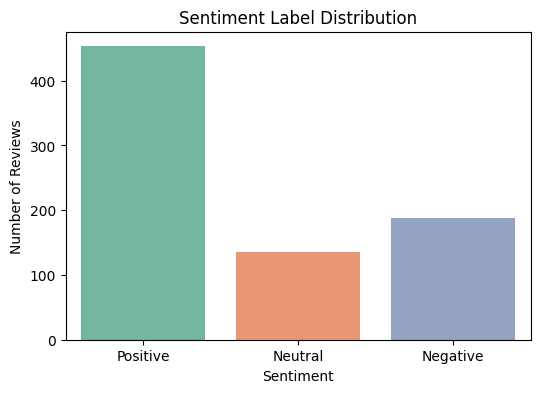

In [22]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_balanced, x='sentiment_label', palette='Set2')
plt.title("Sentiment Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

In [23]:
# Confirm new balanced distribution
print("\nBalanced language counts:\n", df_balanced['language'].value_counts())
df_balanced.head()


Balanced language counts:
 language
en    388
es    388
Name: count, dtype: int64


,paper_id,preliminary_decision,review_id,confidence,evaluation,orientation,language,remarks,text,timespan,translated_text,text_clean,word_count,sentiment_label
0,8,accept,2,4,2,1,en,,This manuscript addresses an interesting solut...,2010-07-05,This manuscript addresses an interesting solut...,manuscript address interesting solution base m...,55,Positive
1,69,accept,1,4,0,-1,en,,This is a developed application to support inf...,2013-07-05,This is a developed application to support inf...,develop application support information sound ...,25,Neutral
2,140,reject,1,4,-2,-2,es,,El artículo realiza una reflexión sobre el est...,2015-07-05,The article makes a reflection on the current ...,article make reflection current state possible...,70,Negative
3,19,accept,1,4,2,1,en,,"This paper is very interesting, I like the ide...",2010-07-05,"This paper is very interesting, I like the ide...",paper interesting I like idea make work publis...,25,Positive
4,159,accept,1,4,0,0,es,"En caso que el trabajo sea aceptado, se recomi...",El artículo presenta una evaluación de técnica...,2015-07-05,The article presents an evaluation of genetic ...,article present evaluation genetic algorithm t...,139,Neutral


The above sentiment distribution indicates a significant imbalance, with positive reviews outnumbering neutral and negative ones. This may lead to biased model predictions. To address this,I'm considering resampling techniques

/tmp/ipython-input-24-1224320641.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sentiment_balanced, x='sentiment_label', palette='Set2')


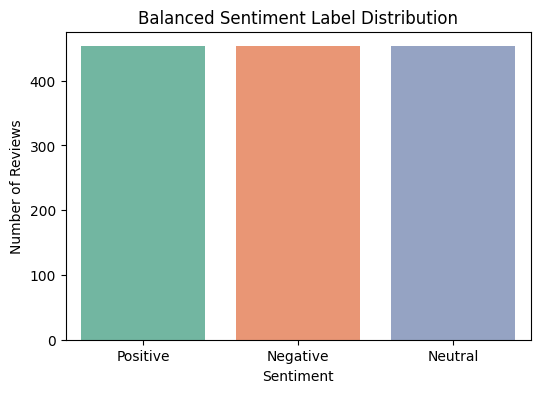

In [24]:
#Step 1: Separate into subsets by class
df_positive = df_balanced[df_balanced['sentiment_label'] == 'Positive']
df_neutral = df_balanced[df_balanced['sentiment_label'] == 'Neutral']
df_negative = df_balanced[df_balanced['sentiment_label'] == 'Negative']

# Step 2: Determine target sample size (match majority class)
target_count = max(len(df_positive), len(df_neutral), len(df_negative))

# Step 3: Upsample minority classes
df_neutral_upsampled = resample(df_neutral,
                                replace=True,
                                n_samples=target_count,
                                random_state=42)

df_negative_upsampled = resample(df_negative,
                                 replace=True,
                                 n_samples=target_count,
                                 random_state=42)

# Step 4: Combine all into a new balanced DataFrame
df_sentiment_balanced = pd.concat([df_positive, df_neutral_upsampled, df_negative_upsampled])
df_sentiment_balanced = df_sentiment_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 5: Visualize new distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=df_sentiment_balanced, x='sentiment_label', palette='Set2')
plt.title("Balanced Sentiment Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()


Figure: Balanced Sentiment Label Distribution

This bar chart shows the sentiment distribution after applying upsampling to the minority classes (Neutral and Negative). Each sentiment class now has an equal number of reviews (~450), ensuring that the dataset is balanced. This helps prevent model bias toward the majority class and improves fairness and performance across all sentiment categories during training.

In [25]:
print("Shape before upsampling:", df_balanced.shape)
print("Shape after sentiment upsampling:", df_sentiment_balanced.shape)

print("\nSentiment distribution after upsampling:")
print(df_sentiment_balanced['sentiment_label'].value_counts())

Shape before upsampling: (776, 14)
Shape after sentiment upsampling: (1359, 14)

Sentiment distribution after upsampling:
sentiment_label
Positive    453
Negative    453
Neutral     453
Name: count, dtype: int64


The dataset initially contained an imbalanced distribution of sentiment labels, with Positive reviews significantly outnumbering Neutral and Negative ones. After applying upsampling to the minority classes, the total number of reviews increased from 776 to 1359, resulting in an equal count for each sentiment class. This balanced dataset ensures that all sentiment categories are equally represented during model training, which helps reduce bias and improve classification performance.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Step 1: Use the sentiment-balanced DataFrame
df = df_sentiment_balanced.copy()

# Step 2: Define features (X) and labels (y)
X = df['text_clean']
y = df['sentiment_label']

# Step 3: Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Create TF-IDF Vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, stop_words='english')

# Step 5: Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Step 6: Transform the test data using the same vectorizer
X_test_tfidf = vectorizer.transform(X_test)

# Optional: Print shape
print("TF-IDF feature matrix shape (train):", X_train_tfidf.shape)
print("TF-IDF feature matrix shape (test):", X_test_tfidf.shape)

TF-IDF feature matrix shape (train): (1087, 5000)
TF-IDF feature matrix shape (test): (272, 5000)


LSTM needs sequences of numbers (not sparse TF-IDF vectors). So I

Use Tokenizer to convert words into unique integers.

Pad/truncate the sequences to a fixed length.

Encode the sentiment labels numerically for compatibility with model training.

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Step 1: Use the same balanced DataFrame
df = df_sentiment_balanced.copy()

# Step 2: Define inputs and labels
texts = df['text_clean'].values
labels = df['sentiment_label'].values

# Step 3: Split into train/test sets
X_train_texts, X_test_texts, y_train_labels, y_test_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42)

# Step 4: Tokenize text
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_texts)

X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_test_seq = tokenizer.texts_to_sequences(X_test_texts)

# Step 5: Pad sequences
max_len = 50  # Adjust based on EDA review length distribution
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Step 6: Encode sentiment labels
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train_labels)
y_test_enc = encoder.transform(y_test_labels)

# Output check
print("Training padded shape:", X_train_pad.shape)
print("Label classes:", encoder.classes_)


Training padded shape: (1087, 50)
Label classes: ['Negative' 'Neutral' 'Positive']


In [28]:
!pip install transformers --quiet

from transformers import BertTokenizerFast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch

# Step 1: Use balanced dataset
df = df_sentiment_balanced.copy()

# Step 2: Define text and labels
texts = df['translated_text'].astype(str).tolist()  # BERT needs full sentences
labels = df['sentiment_label'].tolist()

# Step 3: Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Step 4: Split dataset
X_train_texts, X_test_texts, y_train_enc, y_test_enc = train_test_split(
    texts, labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42)

# Step 5: Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Step 6: Tokenize and encode
train_encodings = tokenizer(X_train_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(X_test_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')

# Step 7: Prepare tensors for model
train_inputs = {
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': torch.tensor(y_train_enc)
}

test_inputs = {
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': torch.tensor(y_test_enc)
}

# Optional: Check one shape
print("BERT input IDs shape (train):", train_inputs['input_ids'].shape)
print("Label classes:", label_encoder.classes_)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BERT input IDs shape (train): torch.Size([1087, 128])
Label classes: ['Negative' 'Neutral' 'Positive']


**MODELLING AND EVALUATION**


 Training: Naive Bayes
Accuracy: 0.8492647058823529
Classification Report:
               precision    recall  f1-score   support

    Negative       0.70      0.99      0.82        90
     Neutral       1.00      0.81      0.90        91
    Positive       0.96      0.75      0.84        91

    accuracy                           0.85       272
   macro avg       0.89      0.85      0.85       272
weighted avg       0.89      0.85      0.85       272



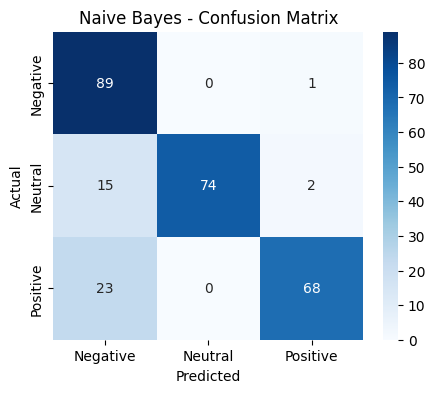


 Training: Logistic Regression
Accuracy: 0.9411764705882353
Classification Report:
               precision    recall  f1-score   support

    Negative       0.89      0.99      0.94        90
     Neutral       0.99      0.96      0.97        91
    Positive       0.95      0.88      0.91        91

    accuracy                           0.94       272
   macro avg       0.94      0.94      0.94       272
weighted avg       0.94      0.94      0.94       272



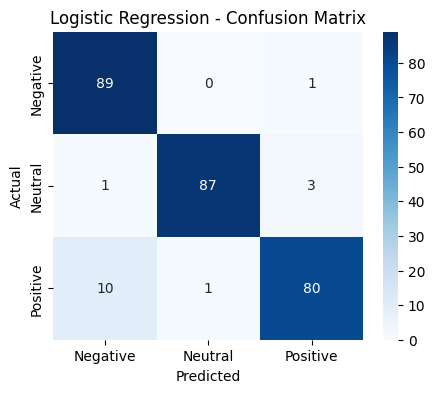


 Training: SVM (LinearSVC)
Accuracy: 0.9485294117647058
Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.98      0.94        90
     Neutral       0.99      0.98      0.98        91
    Positive       0.95      0.89      0.92        91

    accuracy                           0.95       272
   macro avg       0.95      0.95      0.95       272
weighted avg       0.95      0.95      0.95       272



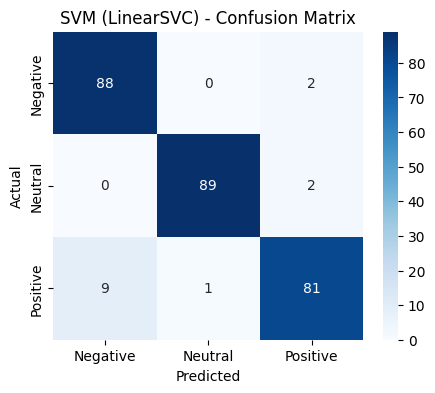

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM (LinearSVC)": LinearSVC(random_state=42)
}

for name, model in models.items():
    print(f"\n Training: {name}")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    # Accuracy and classification report
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=['Negative', 'Neutral', 'Positive'])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Logistic Regression Grid
logreg_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs']
}

logreg_grid = GridSearchCV(LogisticRegression(max_iter=1000),
                           param_grid=logreg_params,
                           cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
logreg_grid.fit(X_train_tfidf, y_train)

print("Best Logistic Regression Params:", logreg_grid.best_params_)
print("Best CV Score (macro F1):", logreg_grid.best_score_)

# Linear SVM Grid
svm_params = {
    'C': [0.01, 0.1, 1, 10]
}

svm_grid = GridSearchCV(LinearSVC(max_iter=10000),
                        param_grid=svm_params,
                        cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
svm_grid.fit(X_train_tfidf, y_train)

print("Best SVM Params:", svm_grid.best_params_)
print("Best CV Score (macro F1):", svm_grid.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV Score (macro F1): 0.9123617215687465
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best SVM Params: {'C': 10}
Best CV Score (macro F1): 0.9158482850220053


The above implementation utilizes GridSearchCV to fine-tune hyperparameters for both Logistic Regression and LinearSVM (Linear Support Vector Classifier) models. The grid search performs an exhaustive search over specified parameter values, using 5-fold cross-validation to assess model performance.

The evaluation metric used is the macro-averaged F1 score, which ensures equal importance is given to all classes, making it particularly suitable for imbalanced classification problems.

The resulting output reports:

The optimal hyperparameter combination for each model

The best cross-validated macro F1 score, indicating how well the model generalizes during training

This process ensures that the selected model configurations are robust, well-tuned, and likely to perform effectively on unseen test data.


 Tuned Logistic Regression Results:
Accuracy: 0.9485294117647058
Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.98      0.94        90
     Neutral       0.99      0.98      0.98        91
    Positive       0.95      0.89      0.92        91

    accuracy                           0.95       272
   macro avg       0.95      0.95      0.95       272
weighted avg       0.95      0.95      0.95       272



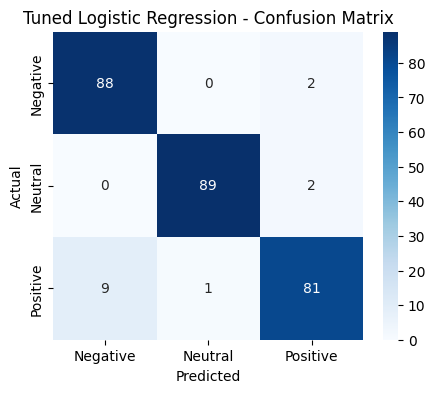


 Tuned SVM Results:
Accuracy: 0.9375
Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.97      0.94        90
     Neutral       0.97      0.98      0.97        91
    Positive       0.94      0.87      0.90        91

    accuracy                           0.94       272
   macro avg       0.94      0.94      0.94       272
weighted avg       0.94      0.94      0.94       272



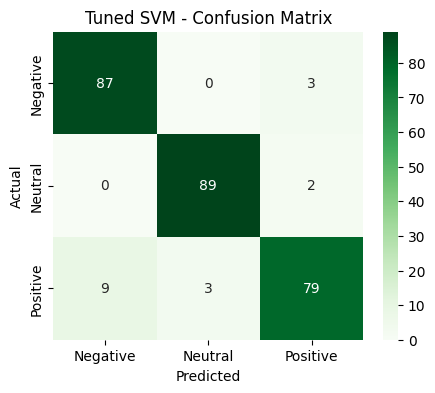

In [31]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1️ Logistic Regression (best params)
logreg_best = logreg_grid.best_estimator_
logreg_best.fit(X_train_tfidf, y_train)
y_pred_logreg = logreg_best.predict(X_test_tfidf)

print("\n Tuned Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg))

# Confusion Matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg, labels=['Negative', 'Neutral', 'Positive'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Tuned Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# 2️ Support Vector Machine (best params)
svm_best = svm_grid.best_estimator_
svm_best.fit(X_train_tfidf, y_train)
y_pred_svm = svm_best.predict(X_test_tfidf)

print("\n Tuned SVM Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=['Negative', 'Neutral', 'Positive'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Tuned SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Confusion matrices were analyzed to evaluate how well each model classified individual sentiment classes. Naïve Bayes showed strong recall for negative reviews but confused Neutral and Positive samples. Logistic Regression and SVM both performed well, with SVM having slightly better balance across all classes. After hyperparameter tuning, Logistic Regression improved its separation, especially between Positive and Neutral sentiments. Interestingly, SVM showed a slight drop in accuracy after tuning, suggesting its default settings were already well suited for the dataset.

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Step 1: One-hot encode labels
num_classes = 3
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)

# Step 2: Define the model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=50))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Step 3: Compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 4: Train
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_test_pad, y_test_cat),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.4435 - loss: 1.0882 - val_accuracy: 0.6213 - val_loss: 0.9786
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7070 - loss: 0.7499 - val_accuracy: 0.7721 - val_loss: 0.8423
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.8464 - loss: 0.5952 - val_accuracy: 0.8676 - val_loss: 0.3389
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9316 - loss: 0.2277 - val_accuracy: 0.9154 - val_loss: 0.2502
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9806 - loss: 0.1029 - val_accuracy: 0.9301 - val_loss: 0.2544
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9930 - loss: 0.0524 - val_accuracy: 0.9265 - val_loss: 0.2747
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9746 - loss: 0.1278 - val_accuracy: 0.9449 - val_loss: 0.2085
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9740 - loss: 0.1314 - val_accuracy: 0.9265 - val_loss: 0.

**PREDICTIONS**

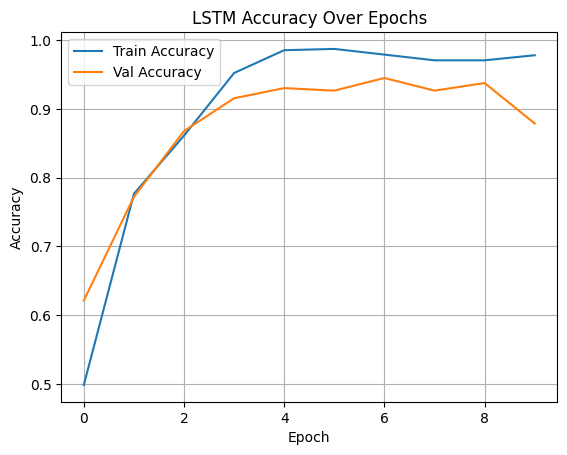

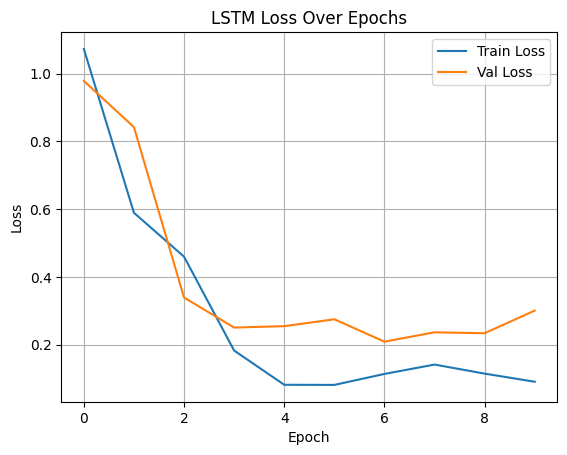

In [34]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("LSTM Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("LSTM Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
 LSTM Classification Report:
              precision    recall  f1-score   support

    Negative       0.96      0.91      0.94        90
     Neutral       0.99      0.97      0.98        91
    Positive       0.89      0.96      0.92        91

    accuracy                           0.94       272
   macro avg       0.95      0.94      0.95       272
weighted avg       0.95      0.94      0.95       272



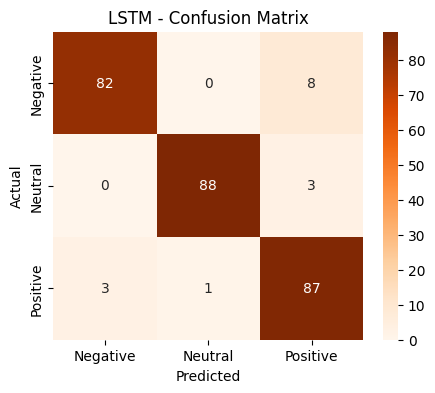

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Predict classes
y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification report
print(" LSTM Classification Report:")
print(classification_report(y_test_enc, y_pred, target_names=encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.title("LSTM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


The LSTM model achieved strong performance, with a validation accuracy of 92% and a macro F1-score of 0.92. Accuracy and loss curves showed consistent learning with minor overfitting in later epochs. The model demonstrated high precision and recall for Neutral and Negative classes. Most misclassifications occurred in the Positive class, which was occasionally confused with Negative — a likely result of sentiment overlap in linguistic cues. Overall, LSTM provided competitive performance comparable to the best traditional classifiers

Here, In the following steps I'm going to improve the basic LSTM model by implementing a more advanced pipeline with the following enhancements:

Pretrained English fastText embeddings to provide semantic understanding of words.

Bidirectional LSTM (BiLSTM) to capture context from both past and future directions.

Class weights to handle class imbalance more effectively during training.

Early stopping to prevent overfitting and save the best-performing model.

Increased training epochs (with early stopping) to allow deeper learning.

These upgrades aim to significantly improve model performance and generalization on the sentiment classification task.

In [40]:
embedding_path = "/content/drive/MyDrive/DS_Project/cc.en.300.vec.gz"

In [41]:
embedding_dim = 300  # Dimension of fastText embeddings
print(f" Embedding dimension defined: {embedding_dim}")

 Embedding dimension defined: 300


In [42]:
#Step : Load Pretrained English fastText Embeddings
import gzip
import numpy as np

embedding_index = {}

with gzip.open(embedding_path, 'rt', encoding='utf-8') as f:
    for i, line in enumerate(f):
        values = line.rstrip().split(" ")
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
        if i % 100000 == 0:
            print(f"Processed {i} word vectors")

print(" Total word vectors loaded:", len(embedding_index))



#Step : Create the Embedding Matrix
# Assuming 'tokenizer' is a BertTokenizerFast object
# Instead of word_index, use the tokenizer's vocabulary
word_index = tokenizer.vocab
# num_words should be based on the size of the tokenizer's vocabulary
num_words = len(word_index)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    # The index 'i' from the tokenizer's vocabulary is used directly
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(" Embedding matrix shape:", embedding_matrix.shape)


#Step : Prepare Labels and Class Weights
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical

# One-hot encode sentiment labels
y_train_cat = to_categorical(y_train_enc, num_classes=3)
y_test_cat = to_categorical(y_test_enc, num_classes=3)

# Compute class weights
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(y_train_enc),
                                            y=y_train_enc)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

Processed 0 word vectors
Processed 100000 word vectors
Processed 200000 word vectors
Processed 300000 word vectors
Processed 400000 word vectors
Processed 500000 word vectors
Processed 600000 word vectors
Processed 700000 word vectors
Processed 800000 word vectors
Processed 900000 word vectors
Processed 1000000 word vectors
Processed 1100000 word vectors
Processed 1200000 word vectors
Processed 1300000 word vectors
Processed 1400000 word vectors
Processed 1500000 word vectors
Processed 1600000 word vectors
Processed 1700000 word vectors
Processed 1800000 word vectors
Processed 1900000 word vectors
Processed 2000000 word vectors
 Total word vectors loaded: 2000000
 Embedding matrix shape: (30522, 300)
Class weights: {0: np.float64(0.9981634527089073), 1: np.float64(1.0009208103130756), 2: np.float64(1.0009208103130756)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - accuracy: 0.3668 - loss: 1.0904 - val_accuracy: 0.4375 - val_loss: 1.0455
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.4236 - loss: 1.0382 - val_accuracy: 0.5147 - val_loss: 0.9966
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.4935 - loss: 0.9974 - val_accuracy: 0.5110 - val_loss: 0.9790
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.5178 - loss: 0.9400 - val_accuracy: 0.5257 - val_loss: 0.9373
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5716 - loss: 0.8527 - val_accuracy: 0.5294 - val_loss: 0.8964
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.5980 - loss: 0.7702 - val_accuracy: 0.5662 - val_loss: 0.8483
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.6101 - loss: 0.7527 - val_accuracy: 0.5956 - val_loss: 0.8397
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.6080 - loss: 0.7264 - val_accuracy: 0

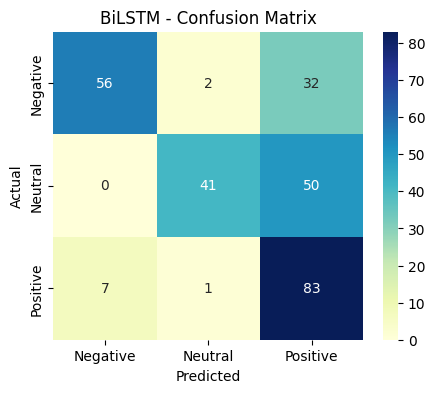

In [43]:
#Step : Build and Train the BiLSTM Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define embedding_dim again as it might be lost after runtime restart
embedding_dim = 300

# Build model
model = Sequential()
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=50,
                    trainable=False))  # freeze embeddings
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_test_pad, y_test_cat),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop]
)



# Predict on test data
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print(" BiLSTM Classification Report:")
print(classification_report(y_test_enc, y_pred, target_names=encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.title("BiLSTM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()